In [1]:
# To support both python 2 and python 3# To su 
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

###  PCA with a linear Autoencoder

In [6]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Normalize the data:

In [10]:
from  sklearn.preprocessing  import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [8]:
import  tensorflow  as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

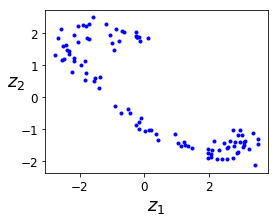

In [14]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

### Stacked Autoencoders¶


In [16]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Train all layers at once


In [17]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

Now let's train it! Note that we don't feed target values (y_batch is not used). This is unsupervised training.

In [18]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0 Train MSE: 0.022036878
1 Train MSE: 0.01213752
2 Train MSE: 0.010648466
3 Train MSE: 0.010232604
4 Train MSE: 0.010744953


In [19]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


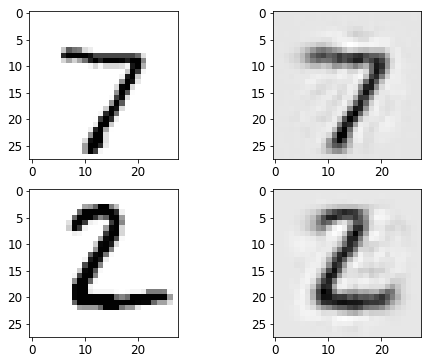

In [21]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")


### Tying weights

In [22]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [23]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [24]:
saver = tf.train.Saver()


In [25]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.015066842
1 Train MSE: 0.016488561
2 Train MSE: 0.017375804
3 Train MSE: 0.016878229
4 Train MSE: 0.015587644


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


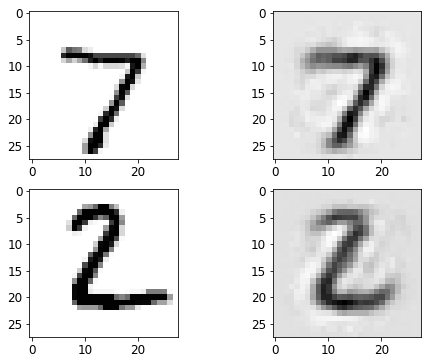

In [26]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

### Training one Autoencoder at a time in multiple graphs¶


In [27]:
reset_graph()
from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [28]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.018563889
1 Train MSE: 0.018759778
2 Train MSE: 0.018457344
3 Train MSE: 0.01923987
0 Train MSE: 0.004228032
1 Train MSE: 0.0048053823
2 Train MSE: 0.0046751755
3 Train MSE: 0.004376104


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [29]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

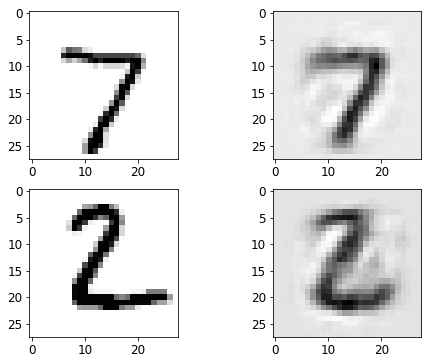

In [30]:
show_reconstructed_digits(X, outputs)

### Training one Autoencoder at a time in a single graph¶


Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).



In [33]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.0074068382
1 Train MSE: 0.0078287525
2 Train MSE: 0.007728056
3 Train MSE: 0.007408975
Training phase #2
0 Train MSE: 0.41791442
1 Train MSE: 0.0060225446
2 Train MSE: 0.0029557692
3 Train MSE: 0.0024973946
Test MSE: 0.009807541


### Cache the frozen layer outputs¶


In [38]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007538226
1 Train MSE: 0.007754633
2 Train MSE: 0.007343643
3 Train MSE: 0.007837738
Training phase #2
0 Train MSE: 0.22196436
1 Train MSE: 0.0044949315
2 Train MSE: 0.0024256888
3 Train MSE: 0.0020209672
Test MSE: 0.009781326


### Visualizing the Reconstructions¶


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


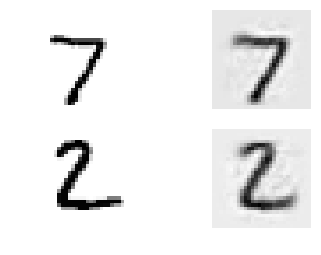

In [39]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Visualizing the extracted features¶


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


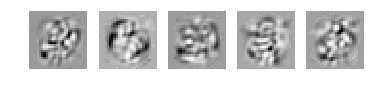

In [41]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

plt.show()                          # not shown

### Unsupervised pretraining¶

Let's create a small neural network for MNIST classification:



In [44]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [45]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.97333336 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.936
2 Train accuracy: 0.97333336 Test accuracy: 0.9382
3 Train accuracy: 0.9866667 Test accuracy: 0.9491


Now reusing the first two layers of the autoencoder we pretrained:



In [46]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.9266667	Test accuracy: 0.9273
1 Train accuracy: 0.98	Test accuracy: 0.9402
2 Train accuracy: 0.98	Test accuracy: 0.9445
3 Train accuracy: 0.98	Test accuracy: 0.9484
